In [1]:
# various import statements
import os
import sklearn
from sklearn import cluster
import pandas as pd
import scanpy as sc
import scvi
import inspect
import tqdm
import numpy as np
from collections import defaultdict
import torch
import torch.nn as nn
from torch.nn.functional import softplus, softmax
from torch.distributions import constraints
import seaborn
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
import pyro.optim
from pyro.infer import SVI
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import re

sc.settings.figdir=os.path.expanduser('~/WbFigures/SpeciesDivergenceNoScaling')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

cuda:0


In [2]:
import sys
sys.path.append('/home/matthew.schmitz/Matthew/code/scANTIPODE/antipode/')
import antipode_model
from antipode_model import *
import model_functions
from model_functions import *
import model_distributions
from model_distributions import *
import model_modules
from model_modules import *
import train_utils
from train_utils import *
import plotting
from plotting import *

import importlib
antipode_model=importlib.reload(antipode_model)
from antipode_model import *

import importlib
model_modules=importlib.reload(model_modules)
from model_modules import *

model_functions=importlib.reload(model_functions)
from model_functions import *

import importlib
model_distributions=importlib.reload(model_distributions)
from model_distributions import *

import importlib
train_utils=importlib.reload(train_utils)
from train_utils import *

import importlib
plotting=importlib.reload(plotting)
from plotting import *



In [3]:
class AntipodeTrainingMixin:
    '''
    Mixin class providing functions to actually run ANTIPODE
    can use supervised taxonomy by training only phase2
    '''
    
    def save_params_to_uns(self,prefix=''):
        pstore=param_store_to_numpy()
        pstore={n:pstore[n] for n in pstore.keys() if not re.search('encoder|classifier',n)}
        self.adata_manager.adata.uns[prefix+'param_store']=pstore

    def store_outputs(self,device='cuda',prefix=''):
        self.save_params_to_uns(prefix='')
        self.to('cpu')
        self.eval()
        antipode_outs=get_antipode_outputs(self,batch_size=2048,device=device)
        taxon=antipode_outs[1][0]
        self.adata_manager.adata.obsm['X_antipode']=antipode_outs[0][0]
        self.adata_manager.adata.obs['psi']=antipode_outs[1][1]
        level_edges=[numpy_hardmax(self.adata_manager.adata.uns['param_store']['edges_'+str(i)],axis=-1) for i in range(len(self.level_sizes)-1)]
        levels=self.tree_convergence_bottom_up.just_propagate(scipy.special.softmax(taxon[...,-self.level_sizes[-1]:],axis=-1),level_edges,s=torch.ones(1))
        prop_taxon=np.concatenate(levels,axis=-1)
        self.adata_manager.adata.obsm['taxon_probs']=prop_taxon
        levels=self.tree_convergence_bottom_up.just_propagate(numpy_hardmax(levels[-1],axis=-1),level_edges,s=torch.ones(1))
        for i in range(len(levels)):
            cur_clust=prefix+'level_'+str(i)
            self.adata_manager.adata.obs[cur_clust]=levels[i].argmax(1)
            self.adata_manager.adata.obs[cur_clust]=self.adata_manager.adata.obs[cur_clust].astype(str)
        self.adata_manager.adata.obs[prefix+'antipode_cluster'] = self.adata_manager.adata.obs.apply(lambda x: '_'.join([x[prefix+'level_'+str(i)] for i in range(len(levels))]), axis=1)
    
    def train_phase_1(self,max_steps,print_every=10000,device='cuda',max_learning_rate=0.001,num_particles=3,one_cycle_lr=True,steps=0,batch_size=32):
        #particle phase
        steps=steps
        print(self.fields)
        print(self.field_types)
        dataloader=scvi.dataloaders.AnnDataLoader(self.adata_manager,batch_size=32,drop_last=True,shuffle=True,data_and_attributes=self.field_types)#supervised_field_types for supervised step
        scheduler=pyro.optim.OneCycleLR({'max_lr':max_learning_rate,'total_steps':max_steps,'div_factor':100,'optim_args':{},'optimizer':torch.optim.Adam}) if one_cycle_lr else pyro.optim.ClippedAdam({'lr':max_learning_rate,'lrd':(1-(5e-6))})
        elbo = pyro.infer.JitTrace_ELBO(num_particles=num_particles,strict_enumeration_warning=False)
        svi = SVI(self.model, self.guide, scheduler, elbo)
        self.train()
        self.zl_encoder.train()
        
        self=self.to(device)
        self.set_approx(True)
        loss_tracker=[]
        pbar = tqdm.tqdm(total=max_steps, position=0)
        done=False
        while steps < max_steps:
            for x in dataloader:
                x['step']=torch.ones(1).to(device)*steps
                x=[x[k].to(device) if k in x.keys() else torch.zeros(1) for k in self.args]
                loss=svi.step(*x)
                steps+=1
                if steps<max_steps-1:
                    scheduler.step()
                else:
                    break
                pbar.update(1)
                loss_tracker.append(loss)
                if steps%print_every == 0:
                    # Tell the scheduler we've done one epoch.
                    pbar.write("[Step %02d]  Loss: %.5f" % (steps, np.mean(loss_tracker[-print_every:])))
        
        pbar.close()
        allDone()
        print("Finished training!")
        return(loss_tracker)

    def prepare_phase_2(self):
        '''Run this if not running in supervised only mode (JUST phase2 with provided obsm clustering), runs kmeans, resets tree edges and locs'''
        kmeans = sklearn.cluster.MiniBatchKMeans(n_clusters=self.level_sizes[-1],init='k-means++',max_iter=1000,reassignment_ratio=0.001,n_init=100,random_state=0).fit(self.adata_manager.adata.obsm['X_antipode'])
        self.adata_manager.adata.obs['kmeans']=kmeans.labels_
        self.adata_manager.adata.obs['kmeans']=self.adata_manager.adata.obs['kmeans'].astype(str).astype('category')
        self.adata_manager.adata.obsm['kmeans_onehot']=numpy_onehot(self.adata_manager.adata.obs['kmeans'].cat.codes,num_classes=self.level_sizes[-1]) #yoh=yoh+1e-10;yoh=oh/oh.sum(-1).reshape(-1,1)#for relaxed
        new_locs=torch.concatenate(
            [pyro.param('locs').new_zeros(sum(self.level_sizes[:-1]),pyro.param('locs').shape[1]),
             torch.tensor(kmeans.cluster_centers_,device=pyro.param('locs').device)],
             axis=0)
        pyro.get_param_store().__setitem__('locs',new_locs)
        pyro.get_param_store().__setitem__('locs_dynam',new_locs.new_zeros(new_locs.shape))
        for n in pyro.get_param_store():
            if 'edge' in n:
                pyro.get_param_store().__setitem__(n,pyro.param(n).new_zeros(pyro.param(n).shape))
        
    def train_phase_2(self,max_steps, taxon_label='kmeans_onehot', print_every=10000, device='cuda', max_learning_rate=0.001, num_particles=1, one_cycle_lr=False, steps=0, batch_size=32):
        '''empirically works best and fastest with one_cycle_lr=False'''
        steps=steps
        supervised_field_types=self.field_types.copy()
        supervised_fields=self.fields.copy()
        supervised_field_types["taxon"]=np.float32
        self.adata_manager.register_new_fields([make_field('taxon',('obsm',taxon_label))])
        class_dataloader=scvi.dataloaders.AnnDataLoader(self.adata_manager, batch_size=batch_size, drop_last=True, shuffle=True, data_and_attributes=supervised_field_types)
        scheduler=pyro.optim.OneCycleLR({'max_lr':max_learning_rate,'total_steps':max_steps, 'div_factor':100,'optim_args':{},'optimizer':torch.optim.Adam}) if one_cycle_lr else pyro.optim.ClippedAdam({'lr':max_learning_rate,'lrd':(1-(5e-6))})
        elbo = pyro.infer.JitTrace_ELBO(num_particles=num_particles,strict_enumeration_warning=False)
        svi = SVI(self.model, self.guide, scheduler, elbo)
        
        self.train()
        self=self.to(device)
        self.set_approx(False)
        loss_tracker=[]
        #for steps in range(max_steps):
        pbar = tqdm.tqdm(total=max_steps, position=0)
        done=False
        while steps < max_steps:
            for x in class_dataloader:
                x['step']=torch.ones(1).to(device)*steps
                x=[x[k].to(device) if k in x.keys() else torch.zeros(1) for k in self.args]
                loss=svi.step(*x)
                steps+=1
                if steps<=max_steps-1:
                    #scheduler.step()
                    pass
                else:
                    break
                pbar.update(1)
                loss_tracker.append(loss)
                if steps%print_every == 0:
                    # Tell the scheduler we've done one epoch.
                    pbar.write("[Step %02d]  Loss: %.5f" % (steps, np.mean(loss_tracker[-print_every:])))
        
        pbar.close()
        allDone()
        print("Finished training!")
        return(loss_tracker)
        
    def train_phase_3(self,max_steps,print_every=10000,device='cuda',max_learning_rate=0.001,num_particles=3,one_cycle_lr=True,steps=0,batch_size=32):
        steps=steps
        dataloader=scvi.dataloaders.AnnDataLoader(self.adata_manager,batch_size=batch_size,drop_last=True,shuffle=True,data_and_attributes=self.field_types)#supervised_field_types for supervised step
        scheduler=pyro.optim.OneCycleLR({'max_lr':max_learning_rate,'total_steps':max_steps,'div_factor':100,'optim_args':{},'optimizer':torch.optim.Adam}) if one_cycle_lr else pyro.optim.ClippedAdam({'lr':max_learning_rate,'lrd':(1-(5e-6))})
        elbo = pyro.infer.JitTraceEnum_ELBO(num_particles=num_particles,strict_enumeration_warning=False)
        svi = SVI(self.model, self.guide, scheduler, elbo)

        loss_tracker=[]
        self.train()
        self=self.to(device)
        self.set_approx(False)
        
        #for steps in range(max_steps):
        pbar = tqdm.tqdm(total=max_steps, position=0)
        done=False
        while steps < max_steps:
            for x in dataloader:
                x['step']=torch.ones(1).to(device)*steps
                x=[x[k].to(device) if k in x.keys() else torch.zeros(1) for k in self.args]
                loss=svi.step(*x)
                steps+=1
                if steps<max_steps-1:
                    #scheduler.step()
                    pass
                else:
                    break
                pbar.update(1)
                loss_tracker.append(loss)
                if steps%print_every == 0:
                    # Tell the scheduler we've done one epoch.
                    pbar.write("[Step %02d]  Loss: %.5f" % (steps, np.mean(loss_tracker[-print_every:])))
        
        pbar.close()
        allDone()
        print("Finished training!")
        return(loss_tracker)


class ANTIPODE(PyroBaseModuleClass,AntipodeTrainingMixin):#
    '''
    ANTIPODE (Single Cell Ancestral Node Taxonomy Inference by Parcellation of Differential Expression) 
    is a variational inference model developed for the simultaneous analysis (DE) and 
    categorization (taxonomy generation) of cell types across evolution (or now any covariate) using single-cell RNA-seq data.
    

    Parameters:
    adata (AnnData): An AnnData object containing the single-cell dataset.
    discov_pair (tuple): A tuple indicating the key and location of the discovery covariate 
                         in the AnnData object. Format: ('key', 'location'), where location is 
                         either 'obs' or 'obsm'.
    batch_pair (tuple): A tuple indicating the key and location of the batch covariate 
                        in the AnnData object. Format: ('key', 'location'), where location is 
                        either 'obs' or 'obsm'.
    num_var (int): Number of variables (features) in the dataset.
    level_sizes (list of int, optional): Sizes of each level in the model's hierarchical structure. 
                                         Defaults to [1, 10, 25, 50].
    num_latent (int, optional): Number of latent dimensions. Defaults to 50.
    scale_factor (float, optional): Scaling factor for data normalization. If None, it is inferred from the data.
    prior_scale (float, optional): Scale of the Laplace prior distributions. Defaults to 100.
    dcd_prior (float, optional): Scale of the prior for the decoder. If None, defaults to a specific inferred value.
    theta_prior (float, optional): Init value for the inverse dispersion of the negative binomial.
    decay_function (callable, optional): A function that defines the decay of certain parameters over iterations.
    max_strictness (float, optional): Maximum strictness parameter for tree convergence. Defaults to 1.
    bi_depth (int, optional): Depth of the tree for the approximation of batch by identity effects. Defaults to 2.
    num_batch_embed (int, optional): Number of batch embeddings. Defaults to 10.
    classifier_hidden (list of int, optional): Sizes of hidden layers for the classifier network. Defaults to [3000, 3000, 3000].
    encoder_hidden (list of int, optional): Sizes of hidden layers for the encoder network. Defaults to [6000, 5000, 3000, 1000].
    '''
    def __init__(self, adata, discov_pair, batch_pair, layer, level_sizes=[1, 10, 25, 50], 
                 num_latent=50, scale_factor=None, prior_scale=100,dcd_prior=None,use_psi=True,loc_as_param=False,zdw_as_param=False,
                 decay_function=None, max_strictness=1., bi_depth=2, num_batch_embed=10,theta_prior=50.,scale_init_val=0.01,
                 classifier_hidden=[3000,3000,3000],encoder_hidden=[6000,5000,3000,1000],phase1_treeest=False,z_transform=None):

        pyro.clear_param_store()

        # Determine num_discov and num_batch from the AnnData object
        self.discov_loc, self.discov_key = discov_pair
        self.batch_loc, self.batch_key = batch_pair
        self.num_discov = adata.obsm[self.discov_key].shape[-1] if self.discov_loc == 'obsm' else len(adata.obs[self.discov_key].unique())
        self.num_batch = adata.obsm[self.batch_key].shape[-1] if self.batch_loc == 'obsm' else len(adata.obs[self.batch_key].unique())
        self.design_matrix = (self.discov_loc == 'obsm')
        self.layer=layer

        self._setup_adata_manager_store: dict[str, type[scvi.data.AnnDataManager]] = {}
        self.num_var = adata.layers[layer].shape[-1]
        self.num_latent = num_latent
        self.scale_factor = scale_factor if scale_factor is not None else 2e2 / (self.num_var * num_labels * num_latent)
        self.level_sizes = level_sizes
        self.num_labels = np.sum(self.level_sizes)
        self.level_indices = np.cumsum([0] + self.level_sizes)
        self.bi_depth = bi_depth
        self.num_bi_depth = sum(self.level_sizes[:self.bi_depth])
        self.num_batch_embed = num_batch_embed
        self.max_strictness = 1.
        self.decay_function = gen_linear_function(2,1) if decay_function is None else decay_function 
        self.temperature = 0.1
        self.epsilon = 1e-10
        self.approx = False
        self.prior_scale = prior_scale
        self.use_psi=use_psi
        self.loc_as_param=loc_as_param
        self.zdw_as_param=zdw_as_param
        self.theta_prior=theta_prior
        self.phase1_treeest=phase1_treeest
        self.scale_init_val=scale_init_val
        
        self.dcd_prior=torch.zeros((self.num_discov,self.num_var)) if dcd_prior is None else dcd_prior#Use this for 
        
        # Initialize plates to be used during sampling
        self.var_plate=pyro.plate('var_plate',self.num_var,dim=-1)
        self.discov_plate=pyro.plate('discov_plate',self.num_discov,dim=-3)
        self.batch_plate=pyro.plate('batch_plate',self.num_batch,dim=-3)
        self.latent_plate=pyro.plate('latent_plate',self.num_latent,dim=-1)
        self.latent_plate2=pyro.plate('latent_plate2',self.num_latent,dim=-2)
        self.label_plate=pyro.plate('label_plate',self.num_labels,dim=-2)
        self.batch_embed_plate=pyro.plate('batch_embed_plate',self.num_batch_embed,dim=-3)
        self.bi_depth_plate=pyro.plate('bi_depth_plate',self.num_bi_depth,dim=-2)

        #Initialize MAP inference modules
        self.dm=MAPLaplaceModule(self,'discov_dm',[self.num_discov,self.num_labels,self.num_latent],[self.discov_plate,self.label_plate,self.latent_plate])
        self.bm=MAPLaplaceModule(self,'batch_dm',[self.num_batch,self.num_labels,self.num_latent],[self.batch_plate,self.label_plate,self.latent_plate])
        self.di=MAPLaplaceModule(self,'discov_di',[self.num_discov,self.num_labels,self.num_var],[self.discov_plate,self.label_plate,self.var_plate])
        self.bei=MAPLaplaceModule(self,'batch_di',[self.num_batch_embed,self.num_bi_depth,self.num_var],[self.batch_embed_plate,self.bi_depth_plate,self.var_plate])
        self.ci=MAPLaplaceModule(self,'cluster_intercept',[self.num_labels, self.num_var],[self.label_plate,self.var_plate])
        self.dc=MAPLaplaceModule(self,'discov_dc',[self.num_discov,self.num_latent,self.num_var],[self.discov_plate,self.latent_plate2,self.var_plate])
        self.zdw=MAPLaplaceModule(self,'z_decoder_weight',[self.num_latent,self.num_var],[self.latent_plate2,self.var_plate],init_val=((2/self.num_latent)*(torch.rand(self.num_latent,self.num_var)-0.5)),param_only=self.zdw_as_param)
        self.zl=MAPLaplaceModule(self,'locs',[self.num_labels,self.num_latent],[self.label_plate,self.latent_plate],param_only=self.loc_as_param)
        self.zs=MAPLaplaceModule(self,'scales',[self.num_labels,self.num_latent],[self.label_plate,self.latent_plate],init_val=self.scale_init_val*torch.ones(self.num_labels,self.num_latent),constraint=constraints.positive,param_only=False)
        self.zld=MAPLaplaceModule(self,'locs_dynam',[self.num_labels,self.num_latent],[self.label_plate,self.latent_plate],param_only=False)
        
        self.tree_edges=TreeEdges(self,straight_through=True)
        self.tree_convergence=TreeConvergence(self,strictness=1.)        
        self.tree_convergence_bottom_up=TreeConvergenceBottomUp(self,strictness=1.)        
        self.z_transform=null_function if z_transform is None else z_transform#centered_sigmoid#torch.special.expit

        if self.design_matrix:
            fields={'s':('layers',self.layer),
            'discov_ind':('obsm',self.discov_key),
            'batch_ind':('obsm',self.batch_key)}
            field_types={"s":np.float32,"batch_ind":np.float32,"discov_ind":np.float32}
        else:
            fields={'s':('layers',self.layer),
            'discov_ind':('obs',self.discov_key),
            'batch_ind':('obs',self.batch_key)}
            field_types={"s":np.float32,"batch_ind":np.int64,"discov_ind":np.int64}

        self.fields=fields
        self.field_types=field_types
        self.setup_anndata(adata, {'discov_ind': discov_pair, 'batch_ind': batch_pair}, self.field_types)
        
        super().__init__()
        # Setup the various neural networks used in the model and guide
        self.z_decoder=ZDecoder(num_latent=self.num_latent, num_var=self.num_var, hidden_dims=[])        
        self.zl_encoder=ZLEncoder(num_var=self.num_var,hidden_dims=encoder_hidden,num_cat_input=self.num_discov,
                    outputs=[(self.num_labels,None),(1,None),(1,softplus)])
        
        self.be_nn=SimpleFFNN(in_dim=self.num_batch,hidden_dims=[1000,500,500],
                    out_dim=self.num_batch_embed)
        
        self.epsilon = 0.006
        #Initialize model in approximation mode
        self.approx=False
        self.prior_scale=prior_scale
        self.args=inspect.getfullargspec(self.model).args[1:]#skip self

    def setup_anndata(self,adata: anndata.AnnData,fields,field_types,**kwargs,):
        
        anndata_fields=[make_field(x,self.fields[x]) for x in self.fields.keys()]
        
        adata_manager = scvi.data.AnnDataManager(
            fields=anndata_fields
        )
        adata_manager.register_fields(adata, **kwargs)
        self.register_manager(adata_manager)
        if fields['discov_ind'][0]=='obsm':
            self.design_matrix=True
            if fields['batch_ind'][0]!='obsm':
                raise Exception("If discov is design matrix, batch must be as well!")


    def register_manager(self, adata_manager: scvi.data.AnnDataManager):
        adata_id = adata_manager.adata_uuid
        self._setup_adata_manager_store[adata_id] = adata_manager
        self.adata_manager=adata_manager
    
    def set_approx(self,b: bool):
        self.approx=b
        
    def model(self, s,discov_ind=torch.zeros(1),batch_ind=torch.zeros(1),step=torch.ones(1),taxon=torch.zeros(1)):
        # Register various nn.Modules (i.e. the decoder/encoder networks) with Pyro
        pyro.module("antipode", self)

        if not self.design_matrix:
            batch=index_to_onehot(batch_ind,[s.shape[0],self.num_batch]).to(s.device)
            discov=index_to_onehot(discov_ind,[s.shape[0],self.num_discov]).to(s.device)
            batch_ind=batch_ind.squeeze()
            discov_ind=discov_ind.squeeze()
        else:
            batch=batch_ind
            discov=discov_ind
        
        minibatch_plate=pyro.plate("minibatch_plate", s.shape[0],dim=-1)
        minibatch_plate2=pyro.plate("minibatch_plate2", s.shape[0],dim=-2)
        cur_strictness=self.decay_function(step, self.max_strictness)
        l = s.sum(1).unsqueeze(-1)
        
        # We scale all sample statements by scale_factor so that the ELBO loss function
        # is normalized wrt the number of datapoints and genes.
        # This helps with numerical stability during optimization.
        with poutine.scale(scale=self.scale_factor):
            # This gene-level parameter modulates the variance of the observation distribution
            s_theta = pyro.param("s_inverse_dispersion", self.theta_prior * s.new_ones(self.num_var),
                               constraint=constraints.positive)
            
            dcd=pyro.param("discov_constitutive_de", self.dcd_prior.to(s.device))
            level_edges=self.tree_edges.model_sample(s,approx=self.approx)
            
            with minibatch_plate:
                beta_prior_a=1.*s.new_ones(self.num_labels)
                beta_prior_a[0]=10.
                if self.approx:#Bernoulli particles approx?
                    taxon_probs = pyro.sample("taxon_probs", dist.Beta(beta_prior_a,s.new_ones(self.num_labels),validate_args=True).to_event(1))
                    taxon = pyro.sample('taxon',dist.RelaxedBernoulli(temperature=0.1*s.new_ones(1),probs=taxon_probs).to_event(1))
                    if self.phase1_treeest:
                        self.tree_convergence.model_sample(taxon,level_edges,s,cur_strictness)#Someday will be possible to properly generate Undirected acyclic graphs here
                else:
                    taxon_probs=pyro.sample('taxon_probs',dist.Dirichlet(s.new_ones(s.shape[0],self.level_sizes[-1]),validate_args=True))
                    if sum(taxon.shape) > 1:#Supervised?
                        if taxon.shape[-1]==self.num_labels:#Totally supervised?
                            pass
                        else:#Only bottom layer is supervised?
                            taxon = pyro.sample("taxon", dist.OneHotCategorical(probs=taxon_probs,validate_args=True),obs=taxon)
                            taxon = torch.concat(self.tree_convergence_bottom_up.just_propagate(taxon,level_edges,s),-1)
                    else:#Unsupervised
                        taxon = pyro.sample("taxon", dist.OneHotCategorical(probs=taxon_probs,validate_args=True),infer={'enumerate':'parallel'})
                        taxon = torch.concat(self.tree_convergence_bottom_up.just_propagate(taxon,level_edges,s),-1)
                    taxon_probs=self.tree_convergence_bottom_up.just_propagate(taxon_probs,level_edges,s,cur_strictness)
                    taxon_probs=torch.cat(taxon_probs,-1)
                   
            locs=self.zl.model_sample(s,scale=fest([taxon_probs],-1))
            scales=self.zs.model_sample(s,scale=fest([taxon_probs],-1))
            locs_dynam=self.zld.model_sample(s,scale=fest([taxon_probs],-1))
            discov_dm=self.dm.model_sample(s,scale=fest([discov,taxon_probs],-1))
            discov_di=self.di.model_sample(s,scale=fest([discov,taxon_probs],-1))
            batch_dm=self.bm.model_sample(s,scale=fest([batch,taxon_probs],-1))
            batch_embed=centered_sigmoid(self.be_nn(batch))
            bei=self.bei.model_sample(s,scale=fest([batch_embed,taxon_probs[...,:self.num_bi_depth]],-1))
            cluster_intercept=self.ci.model_sample(s,scale=fest([taxon_probs],-1))
            
            with minibatch_plate:
                bi=torch.einsum('...bi,...ijk->...bjk',batch_embed,bei)
                bi=torch.einsum('...bj,...bjk->...bk',taxon[...,:self.num_bi_depth],bi)
                psi = centered_sigmoid(pyro.sample('psi',dist.Laplace(s.new_zeros(s.shape[0],1),self.prior_scale*s.new_ones(s.shape[0],1)).to_event(1)))
                psi = 0 if not self.use_psi else psi
                this_locs=oh_index(locs,taxon)
                this_scales=oh_index(scales,taxon)
                z=pyro.sample('z', dist.Normal(this_locs,this_scales+self.epsilon,validate_args=True).to_event(1))
                pyro.sample('z_loc', dist.Normal(this_locs,this_scales+self.epsilon,validate_args=True).to_event(1))

            cur_discov_dm = oh_index1(discov_dm, discov_ind) if self.design_matrix else discov_dm[discov_ind]
            cur_batch_dm = oh_index1(batch_dm, batch_ind) if self.design_matrix else batch_dm[batch_ind]
            cur_dcd = oh_index(dcd, discov) if self.design_matrix else  dcd[discov_ind]
            
            z=z+oh_index2(cur_discov_dm,taxon) + oh_index2(cur_batch_dm,taxon)+(oh_index(locs_dynam,taxon)*psi)
            z=self.z_transform(z)                
            fake_z=oh_index(locs,taxon_probs)+oh_index2(discov_dm[discov_ind],taxon_probs) + oh_index2(batch_dm[batch_ind],taxon_probs)+(oh_index(locs_dynam,taxon_probs)*psi)
            fake_z=self.z_transform(fake_z)
            z_decoder_weight=self.zdw.model_sample(s,scale=fest([fake_z.abs()],-1))
            discov_dc=self.dc.model_sample(s,scale=fest([discov,fake_z.abs()],-1))
            cur_discov_di = oh_index1(discov_di, discov_ind) if self.design_matrix else discov_di[discov_ind]
            cur_discov_dc = oh_index1(discov_dc, discov_ind) if self.design_matrix else discov_dc[discov_ind]
            cur_discov_di=oh_index2(cur_discov_di,taxon)
            cur_cluster_intercept=oh_index(cluster_intercept,taxon)
            
            mu=torch.einsum('...bi,...bij->...bj',z,z_decoder_weight+cur_discov_dc)#+bc
            spliced_mu=mu+cur_dcd+cur_discov_di+cur_cluster_intercept+bi
            spliced_out=torch.softmax(spliced_mu,dim=-1)
            log_mu = (l * spliced_out + 1e-6).log()
            
            with self.var_plate,minibatch_plate2:
                s_dist = dist.NegativeBinomial(total_count=s_theta,logits=log_mu-s_theta.log(),validate_args=True)
                s_out=pyro.sample("s", s_dist, obs=s.int())

    
    # The guide specifies the variational distribution
    def guide(self, s,discov_ind=torch.zeros(1),batch_ind=torch.zeros(1),step=torch.ones(1),taxon=torch.zeros(1)):
        pyro.module("antipode", self)
        
        if not self.design_matrix:
            batch=index_to_onehot(batch_ind,[s.shape[0],self.num_batch]).to(s.device)
            discov=index_to_onehot(discov_ind,[s.shape[0],self.num_discov]).to(s.device)
            batch_ind=batch_ind.squeeze()
            discov_ind=discov_ind.squeeze()
        else:
            batch=batch_ind
            discov=discov_ind
        
        minibatch_plate=pyro.plate("minibatch_plate", s.shape[0])
        cur_strictness=self.decay_function(step, self.max_strictness)
        
        with poutine.scale(scale=self.scale_factor):
            level_edges=self.tree_edges.guide_sample(s,approx=self.approx) 
            with minibatch_plate:
                taxon_logits,psi_loc,psi_scale=self.zl_encoder(s,discov)
                psi=centered_sigmoid(pyro.sample('psi',dist.Normal(psi_loc,psi_scale).to_event(1)))
                psi = 0 if not self.use_psi else psi
                if self.approx:
                    taxon_dist = dist.Delta(safe_sigmoid(taxon_logits),validate_args=True).to_event(1)
                    taxon_probs = pyro.sample("taxon_probs", taxon_dist)
                    taxon = pyro.sample('taxon',dist.RelaxedBernoulli(temperature=self.temperature*s.new_ones(1),probs=taxon_probs).to_event(1))
                    if self.phase1_treeest:
                        self.tree_convergence.guide_sample(taxon,level_edges,s,cur_strictness)
                else:
                    taxon_probs=pyro.sample('taxon_probs',dist.Delta(safe_softmax(taxon_logits[...,-self.level_sizes[-1]:])).to_event(1))
                    if sum(taxon.shape) > 1:
                        pass
                    else:
                        taxon = pyro.sample("taxon", 
                                         dist.OneHotCategorical(probs=taxon_probs,validate_args=True),infer={'enumerate':'parallel'})                    
                    if taxon.shape[-1]<self.num_labels:
                        taxon = torch.concat(self.tree_convergence_bottom_up.just_propagate(taxon,level_edges,s),-1)
                    
                    taxon_probs=self.tree_convergence_bottom_up.just_propagate(taxon_probs[...,-self.level_sizes[-1]:],level_edges,s,cur_strictness)
                    taxon_probs=torch.cat(taxon_probs,-1)
                    

            locs=self.zl.guide_sample(s,scale=fest([taxon_probs],-1))
            scales=self.zs.guide_sample(s,scale=fest([taxon_probs],-1))
            locs_dynam=self.zld.guide_sample(s,scale=fest([taxon_probs],-1))
            discov_dm=self.dm.guide_sample(s,scale=fest([discov,taxon_probs],-1))
            batch_dm=self.bm.guide_sample(s,scale=fest([batch,taxon_probs],-1))
            batch_embed=centered_sigmoid(self.be_nn(batch))
            discov_di=self.di.guide_sample(s,scale=fest([discov,taxon_probs],-1))
            cluster_intercept=self.ci.guide_sample(s,scale=fest([taxon_probs],-1))
            bei=self.bei.guide_sample(s,scale=fest([batch_embed,taxon_probs[...,:self.num_bi_depth]],-1))#maybe should be abs sum bei
            this_locs=oh_index(locs,taxon)
            this_scales=oh_index(scales,taxon)
            z=pyro.sample('z',dist.Normal(this_locs,this_scales).to_event(1))
            if self.design_matrix:
                z=z+oh_index2(oh_index1(discov_dm,discov_ind),taxon) + oh_index2(oh_index1(batch_dm,batch_ind),taxon)+(oh_index(locs_dynam,taxon)*psi)
            else:
                z=z+oh_index2(discov_dm[discov_ind],taxon) + oh_index2(batch_dm[batch_ind],taxon)+(oh_index(locs_dynam,taxon)*psi)
            z=self.z_transform(z)
            fake_z=oh_index(locs,taxon_probs)+oh_index2(discov_dm[discov_ind],taxon_probs) + oh_index2(batch_dm[batch_ind],taxon_probs)+(oh_index(locs_dynam,taxon_probs)*psi)
            fake_z=self.z_transform(fake_z)
            z_decoder_weight=self.zdw.guide_sample(s,scale=fest([fake_z.abs()],-1))
            discov_dc=self.dc.guide_sample(s,scale=fest([discov,fake_z.abs()],-1))
            

In [4]:
# adata=sc.read_h5ad(os.path.expanduser('/home/matthew.schmitz/Matthew/data/cortex_data/v1_combination.h5ad'),backed='r')
# adata=adata[~adata.obs['dataset'].isin(['jorstad_cross_areal','krienen_marmoset']),:]
# adata.write_h5ad(os.path.expanduser('/home/matthew.schmitz/Matthew/data/cortex_data/v1_combination_nojo.h5ad'))

In [5]:
adata=sc.read_h5ad(os.path.expanduser('/home/matthew.schmitz/Matthew/data/cortex_data/v1_combination_nojo.h5ad'),backed='r')
adata

AnnData object with n_obs × n_vars = 464337 × 10019 backed at '/home/matthew.schmitz/Matthew/data/cortex_data/v1_combination_nojo.h5ad'
    obs: 'batch', 'species', 'dataset'
    var: 'homo_sapiens_symbol', 'tupaia_belangeri_ensemblid', 'rousettus_aegyptiacus_ensemblid', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'featureid', 'highly_variable_features', 'hvf_loess', 'hvf_rank', 'mean', 'n_cells', 'percent_cells', 'robust', 'var', 'gene_name', 'gene', 'Biotype', 'Chromosome', 'End', 'Gene', 'Start', 'Accession'
    layers: 'UMIs'

In [6]:
adata.uns['species_colors']=['blue','red','green','yellow','orange','pink','turquoise','magenta']

In [7]:
try:
    pyro.clear_param_store()
    del antipode_model
    torch.cuda.empty_cache()
except:
    pass

In [8]:
num_var=adata.shape[1]
batch_size=32
level_sizes=[1,10,30,125]
num_latent=200
num_labels=sum(level_sizes)
steps=0
max_steps=30000
print_every=5000

# Clear Pyro param store so we don't conflict with previous run
pyro.clear_param_store()
# Fix random number seed to a lucky number
pyro.util.set_rng_seed(13)
# Enable optional validation warnings
pyro.enable_validation(False)

decay_function=gen_linear_function(max_steps,10000)#gen_exponential_decay(5e-6)

# Instantiate instance of model/guide and various neural networks
antipode_model = ANTIPODE(num_latent=num_latent,level_sizes=level_sizes,
                adata=adata,discov_pair=('obs','species'),batch_pair=('obs','batch'),layer='UMIs',
                scale_factor=1e2 / (3*batch_size * num_var * num_labels * num_latent),phase1_treeest=True,
                bi_depth=2,decay_function=decay_function,max_strictness=100,prior_scale=100.,num_batch_embed=10)


<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
I0000 00:00:1706745046.028804  150417 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


# Training Phase 3: Refining the final tree

In [9]:
antipode_model.train_phase_3(max_steps=max_steps,print_every=10000,num_particles=1)
#antipode_model.store_outputs(device=device,prefix='')

  0%|          | 0/30000 [00:00<?, ?it/s]<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

/home/matthew.schmitz/Matthew/code/scANTIPODE/antipode/model_functions.py:218: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if sum(index.shape) == 1:
/home/matthew.schmitz/Matthew/code/scANTIPODE/antipode/model_functions.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this valu

[Step 10000]  Loss: 0.14608


 67%|██████▋   | 20001/30000 [26:31<12:37, 13.20it/s]

[Step 20000]  Loss: 0.12608


 74%|███████▍  | 22195/30000 [29:17<09:53, 13.16it/s]
KeyboardInterrupt



In [11]:
antipode_model.save_params_to_uns(prefix='')
def get_hardened_antipode_outputs(antipode_model,batch_size=2048,device='cuda'):
    design_matrix=False  #3x faster
    
    if antipode_model.discov_key not in antipode_model.adata_manager.adata.obsm.keys():
        onehot_key=antipode_model.discov_key+"_onehot"
        antipode_model.adata_manager.adata.obsm[onehot_key]=numpy_onehot( antipode_model.adata_manager.adata.obs[antipode_model.discov_key].cat.codes)
    else:
        onehot_key=antipode_model.discov_key
    antipode_model.adata_manager.register_new_fields([scvi.data.fields.ObsmField(onehot_key,onehot_key)])       
    field_types={"s":np.float32,onehot_key:np.float32}
    dataloader=scvi.dataloaders.AnnDataLoader(antipode_model.adata_manager,batch_size=32,drop_last=False,shuffle=False,data_and_attributes=field_types)#supervised_field_types for supervised step 
    encoder_outs=batch_output_from_dataloader(dataloader,antipode_model.zl_encoder,batch_size=batch_size,device=device)
    encoder_out=[x.detach().cpu().numpy() for x in encoder_outs]
    return encoder_out

def numpy_centered_sigmoid(x):
    return (scipy.special.expit(x)-0.5)*2

In [12]:
prefix=''
antipode_model.to('cpu')
antipode_model.eval()
antipode_outs=get_hardened_antipode_outputs(antipode_model,batch_size=2048,device=device)
taxon=scipy.special.expit(antipode_outs[0]) if antipode_model.approx else scipy.special.softmax(antipode_outs[0],-1)
this_locs=np.einsum('bi,ij->bj',taxon,adata.uns[prefix+'param_store']['locs'])
psi=centered_sigmoid(torch.tensor(antipode_outs[1])).numpy()
antipode_model.adata_manager.adata.obs['psi']=psi
psi_effect=(np.einsum('bi,ij->bj',taxon,adata.uns[prefix+'param_store']['locs_dynam'])*psi)
antipode_model.adata_manager.adata.obsm['X_antipode']=this_locs+psi_effect
level_edges=[numpy_hardmax(antipode_model.adata_manager.adata.uns['param_store']['edges_'+str(i)],axis=-1) for i in range(len(antipode_model.level_sizes)-1)]
levels=antipode_model.tree_convergence_bottom_up.just_propagate(scipy.special.softmax(taxon[...,-antipode_model.level_sizes[-1]:],axis=-1),level_edges,s=torch.ones(1))
prop_taxon=np.concatenate(levels,axis=-1)
antipode_model.adata_manager.adata.obsm['taxon_probs']=prop_taxon
levels=antipode_model.tree_convergence_bottom_up.just_propagate(numpy_hardmax(levels[-1],axis=-1),level_edges,s=torch.ones(1))
for i in range(len(levels)):
    cur_clust=prefix+'level_'+str(i)
    antipode_model.adata_manager.adata.obs[cur_clust]=levels[i].argmax(1)
    antipode_model.adata_manager.adata.obs[cur_clust]=antipode_model.adata_manager.adata.obs[cur_clust].astype(str)
antipode_model.adata_manager.adata.obs[prefix+'antipode_cluster'] = antipode_model.adata_manager.adata.obs.apply(lambda x: '_'.join([x[prefix+'level_'+str(i)] for i in range(len(levels))]), axis=1)

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


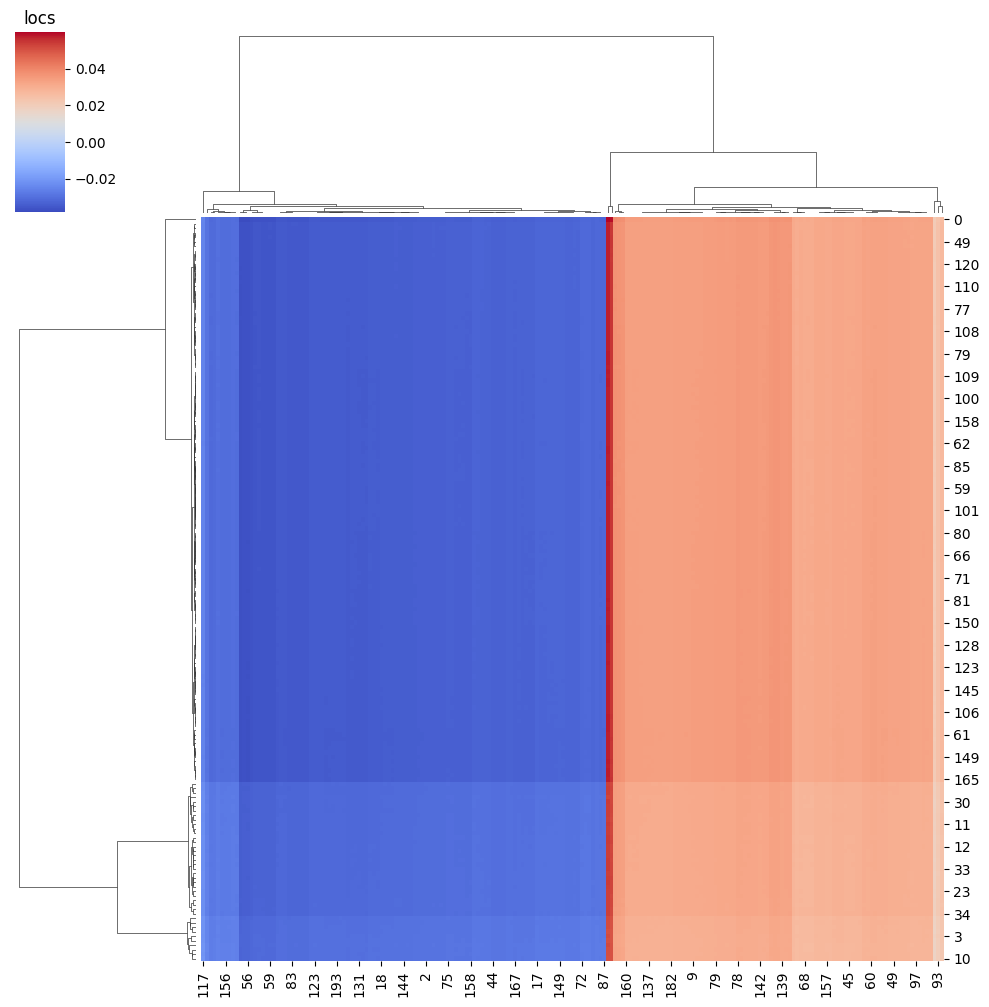

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


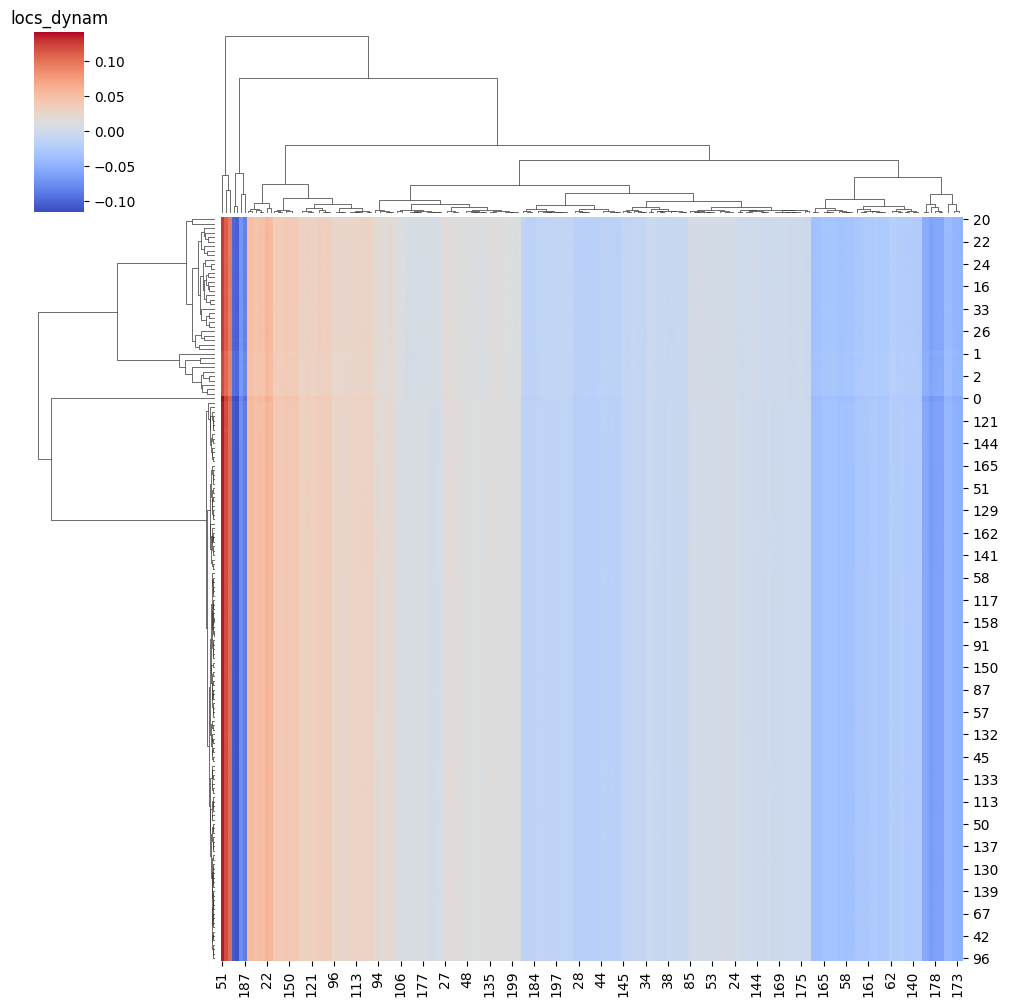

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
 74%|███████▍  | 22195/30000 [30:51<10:51, 11.99it/s]


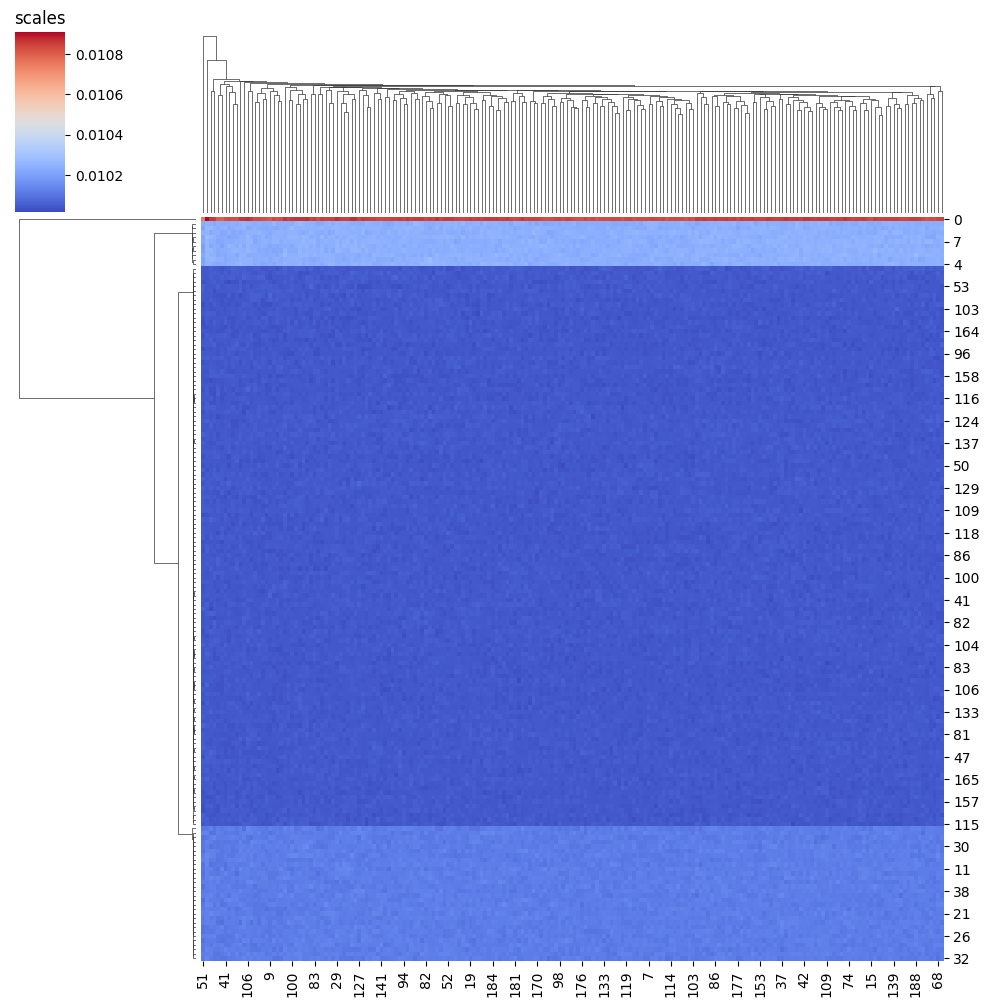

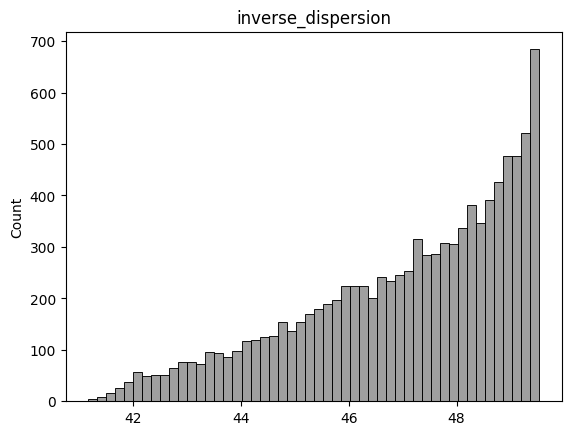

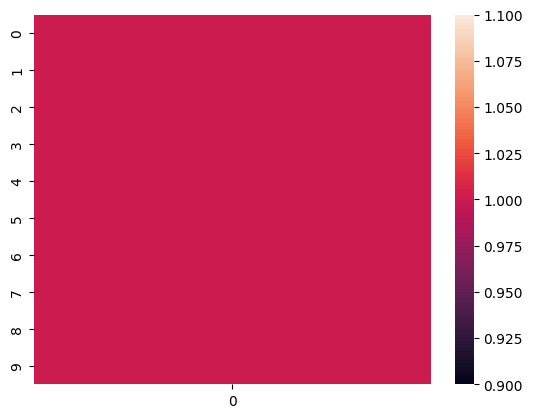

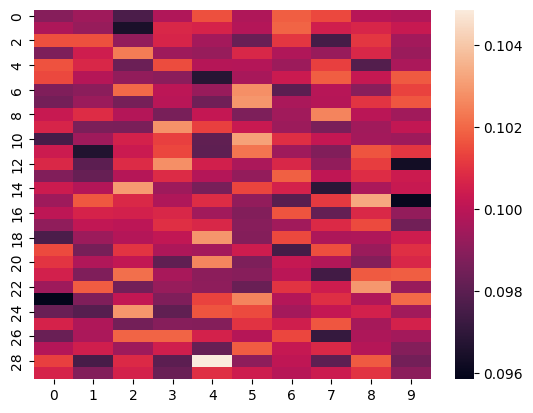

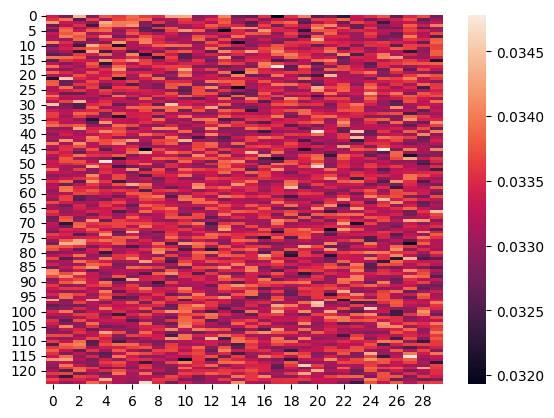

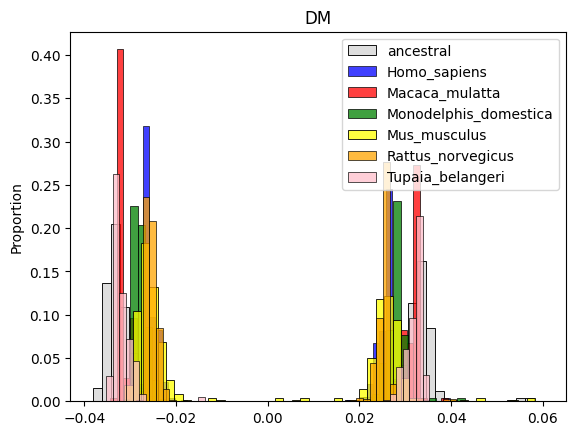

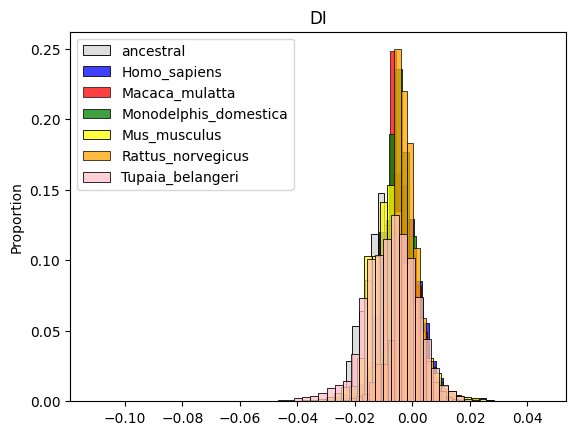

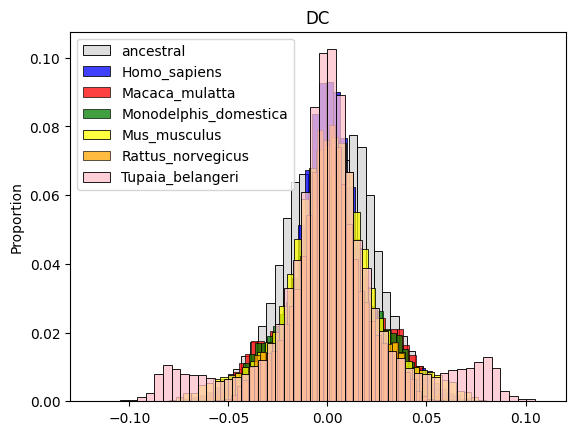

In [13]:
plot_gmm_heatmaps(antipode_model)
plot_tree_edge_weights(antipode_model)
plot_d_hists(antipode_model)

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/pynndescent/pynndescent_.py:346: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style' in a future release. See details at https://numba.readthedocs.io/en/latest/reference/deprecation.html#deprecation-of-old-style-numba-captured-errors
Exception origin:
  File "/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/numba/core/types/functions.py", line 486, in __getnewargs__
    raise ReferenceError("underlying object has vanished")

  init_rp_tree(data, dist, current_graph, leaf_array)
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/pynndescent/pynndescent_.py:348: NumbaPendingDeprecationWarning: Co

Jan 31 04:24:24 PM: Your dataset appears to contain duplicated items (rows); when embedding, you should typically have unique items.
Jan 31 04:24:24 PM: The following items have duplicates [ 47321  47322  47323 ... 110055 110058 110060]


/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


KeyError: 'Could not find key kmeans in .var_names or .obs.columns.'

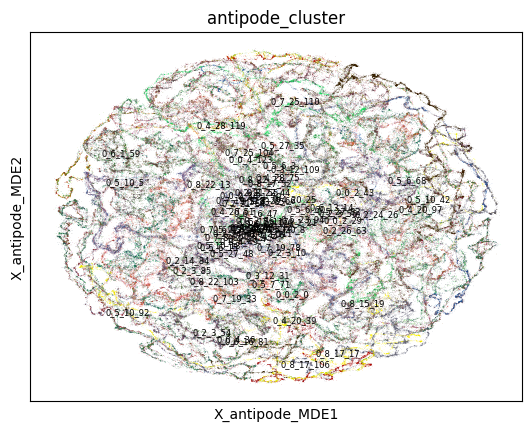

In [14]:
MDE_KEY = "X_antipode_MDE"
adata.obsm[MDE_KEY] = scvi.model.utils.mde(adata.obsm['X_antipode'])
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["antipode_cluster","kmeans"],legend_fontsize=6,legend_fontweight='normal',
    legend_loc='on data',palette=sc.pl.palettes.godsnot_102
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["species"],palette=sc.pl.palettes.godsnot_102
)
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=['dataset'],palette=sc.pl.palettes.godsnot_102
)


In [ ]:
#sc.pl.umap(adata,color=[x for x in adata.obs.columns if 'level' in x]+['antipode_cluster','kmeans'],use_raw=False,legend_loc=None,palette=sc.pl.palettes.godsnot_102)

random_choice=np.random.choice(adata.obs.index,size=100000,replace=False)
random_choice=np.where(adata.obs.index.isin(random_choice))[0]
xdata=adata[random_choice,:]
xdata=xdata.to_memory().copy()
sc.pp.neighbors(xdata,n_neighbors=20, use_rep="X_antipode")
sc.tl.umap(xdata)

sc.pl.umap(xdata,color=['species'],use_raw=False,palette=sc.pl.palettes.godsnot_102)
sc.pl.umap(xdata,color=['psi'],use_raw=False,cmap='coolwarm')
sc.pl.umap(xdata,color=[x for x in adata.obs.columns if 'level' in x]+['antipode_cluster'],use_raw=False,legend_loc=None,palette=sc.pl.palettes.godsnot_102)
xdata.X=xdata.layers['UMIs']
sc.pp.normalize_per_cell(xdata)
sc.pp.log1p(xdata)
sc.pp.scale(xdata,max_value=10)


In [ ]:
gene_list=['RBFOX3','PDGFRA','AQP4','FOXJ1','AIF1','MOG','COL1A2','CD34','COL4A1','NPY','FOXP2','SATB2','RORB','DLX2','PROX1','SCGN','TSHZ1','SLC17A7','TLE4',
           'MEIS2','NKX2-1','LHX6','CRABP1','TSHZ1','FOXG1','PDGFRA','AIF1','AQP4','EDNRB','FOXJ1','CD34','MKI67','RPL7','RPS17','RPL13A','MEF2C']
gene_list=[x for x in gene_list if x in xdata.var.index]
sc.pl.umap(xdata,color=gene_list,cmap='Purples',use_raw=False)

In [ ]:
#adata.write_h5ad('/home/matthew.schmitz/Matthew/1.9.1_run.h5ad')

In [ ]:
xdata.obs['log_n_umi']=np.log10(xdata.X.sum(1)+1)
sc.pl.violin(xdata,groupby='dataset',keys='log_n_umi',rotation=90)

In [ ]:
sc.pl.umap(xdata,color=[x for x in adata.obs.columns if 'level' in x][1:]+['antipode_cluster'],use_raw=False,legend_loc='on data',legend_fontsize=6,legend_fontweight='normal',palette=sc.pl.palettes.godsnot_102)


 74%|███████▍  | 22195/30000 [29:30<09:53, 13.16it/s]

In [ ]:
adata.obs

In [ ]:
cluster_colors

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Example data
np.random.seed(0)
data = adata.uns['param_store']['discov_di'].var(-1)[:,-antipode_model.level_sizes[-1]:]
species = antipode_model.adata_manager.registry['field_registries']['discov_ind']['state_registry']['categorical_mapping']
clusters = [f'Cluster_{i}' for i in range(data.shape[-1])]

df = pd.DataFrame(data, index=species, columns=clusters)

# Annotations for clusters (assuming each cluster has a unique color)
cluster_colors = adata.uns['level_3_colors']
cluster_lut = dict(zip(map(str, clusters), cluster_colors))
cluster_colors = pd.Series(df.columns, index=df.columns).map(cluster_lut)
cluster_colors=cluster_colors.fillna('white')

# Annotations for predicted subclasses (assuming each subclass has a unique color)
# Replace 'subclass_values' with your actual subclass values
level_to_subclass=adata.obs.groupby('level_3')['AIT21_subclass'].value_counts().unstack().idxmax(1)
level_to_subclass.index=list(level_to_subclass.index.astype(int))
for k in range(antipode_model.level_sizes[-1]):
    if k not in level_to_subclass.keys():
        level_to_subclass[k]='nan'
subclasses=[level_to_subclass[k] for k in range(antipode_model.level_sizes[-1])]
subclass_colors = [sc.pl.palettes.godsnot_102[x%len(sc.pl.palettes.godsnot_102)] for x in range(len(sc.pl.palettes.godsnot_102))]#sns.color_palette("Set2", len(subclasses))
subclass_lut = dict(zip(subclasses, subclass_colors))
subclass_lut['nan']='white'
subclass_colors = pd.Series(subclasses, index=df.columns).map(subclass_lut)

# Concatenate the color annotations into a single DataFrame
# Assuming you want these annotations for rows (species)
row_colors = pd.DataFrame({'Subclass': subclass_colors,'Cluster': cluster_colors})
print(row_colors)

# Create the clustermap
g = sns.clustermap(df, col_colors=row_colors, figsize=(12, 8))

# Create a legend for the colors
for label, color in subclass_lut.items():
    g.ax_col_dendrogram.bar(0, 0, color=color, label=label, linewidth=0)
g.ax_col_dendrogram.legend(title="Predicted Subclasses", loc="center", bbox_to_anchor=(0.5, 1.15), ncol=3)

plt.show()
